In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""

# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
import deepxde as dde
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
def generate_evolution_model(a, domain, boundary, width, depth, rate, epochs):

    def pde(x, y):
        dy_tt = dde.grad.hessian(y, x)
        return dy_tt - dy_xx


    main_domain = dde.geometry.Rectangle([0,0],[1,1])
    excision_mask = dde.geometry.Polygon([[0,0], [0, a], [1-a, 1], [1,1], [1, 1-a], [a, 0]])
    geom = main_domain - excision_mask


    ic = dde.icbc.DirichletBC(
        geom,
        lambda x: 1 + a/(x[:, 0:1]),
        lambda x, on_boundary:  np.isclose(x[1], 0),
    )

    dic = dde.icbc.OperatorBC(
    geom,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
    lambda _, on_initial: on_initial,)
    
    
    data = dde.data.PDE(
        geom, pde, [ic, dic], num_domain=500, num_boundary=500)
    

    net = dde.nn.FNN([2] + [width] * depth + [1], "tanh", "Glorot normal")


    model = dde.Model(data, net)
    model.compile("adam", lr=rate)
    losshistory, train_state = model.train(iterations=epochs)
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

    return model
    
    

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import griddata

def plot_evolution_model(a, model):
    def analytic_solution(x, t):
        return 1 - ((a/2)/(t-x)) + ((a/2)/(t+x))
    
    x = np.linspace(0, 1, 256)
    t = np.linspace(0, 1, 256)
    X, T = np.meshgrid(x, t)

    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    prediction = model.predict(X_star, operator=None)
    v = griddata(X_star, prediction[:, 0], (X, T), method="cubic")

    analytic_v = analytic_solution(X, T)
    diff = np.abs(v.T - analytic_v)

    plt.style.use("default")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    vmax = np.percentile(v.flatten(), 90)  # Set threshold as 95th percentile of the data

    im1 = ax1.imshow(
        v.T,
        interpolation="nearest",
        cmap="inferno",
        extent=[0, 1, 0, 1],
        origin="lower",
        aspect="auto",
        vmax=vmax,
        vmin=0
    )
    # ax1.axhline(y=0.2, color='red', linestyle='--')  # Add red horizontal line at t=0.2
    # ax1.axhline(y=0.5, color='green', linestyle='--')  # Add green horizontal line at t=0.4
    # ax1.axhline(y=0.8, color='blue', linestyle='--')  # Add blue horizontal line at t=0.8
    ax1.set_title("$\psi(x,t)$")
    ax1.set_ylabel('t')
    ax1.set_xlabel('x')
    fig.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(
        analytic_v,
        interpolation="nearest",
        cmap="inferno",
        extent=[0, 1, 0, 1],
        origin="lower",
        aspect="auto",
        vmax=vmax,
        vmin=0
    )
    # ax2.axhline(y=0.2, color='red', linestyle='--')  # Add red horizontal line at t=0.2
    # ax2.axhline(y=0.5, color='green', linestyle='--')  # Add green horizontal line at t=0.4
    # ax2.axhline(y=0.8, color='blue', linestyle='--')  # Add blue horizontal line at t=0.8
    ax2.set_title(r'$\psi_{a}(x,t)$')
    ax2.set_xlabel("x")
    ax2.set_ylabel('t')
    fig.colorbar(im2, ax=ax2)

    im3 = ax3.imshow(
        abs(diff),
        interpolation="nearest",
        cmap="inferno",
        extent=[0, 1, 0, 1],
        origin="lower",
        aspect="auto",
        vmax=vmax,
        vmin=0
    )
    # ax3.axhline(y=0.2, color='red', linestyle='--')  # Add red horizontal line at t=0.2
    # ax3.axhline(y=0.5, color='green', linestyle='--')  # Add green horizontal line at t=0.4
    # ax3.axhline(y=0.8, color='blue', linestyle='--')  # Add blue horizontal line at t=0.8
    ax3.set_title(r'$|\psi(x,t)-\psi_{a}(x,t)|$')
    ax3.set_xlabel("x")
    ax3.set_ylabel('t')
    fig.colorbar(im3, ax=ax3)

    inset_axes1 = inset_axes(ax1, width="30%", height="30%", loc="lower right")
    inset_axes1.imshow(
        v.T[90:110, 90:110],
        interpolation="nearest",
        cmap="inferno",
        origin="lower",
        aspect="auto",
        vmax=vmax,
        vmin=0
    )


    inset_axes2 = inset_axes(ax2, width="30%", height="30%", loc="lower right")
    inset_axes2.imshow(
        analytic_v[90:110, 90:110],
        interpolation="nearest",
        cmap="inferno",
        origin="lower",
        aspect="auto",
        vmax=vmax,
        vmin=0
    )
    

    inset_axes3 = inset_axes(ax3, width="30%", height="30%", loc="lower right")
    inset_axes3.imshow(
        abs(diff)[90:110, 90:110],
        interpolation="nearest",
        cmap="inferno",
        origin="lower",
        aspect="auto",
        vmax=vmax,
        vmin=0
    )

    
    inset_axes1.set_xticks([])
    inset_axes1.set_yticks([])

    
    inset_axes2.set_xticks([])
    inset_axes2.set_yticks([])

    
    inset_axes3.set_xticks([])
    inset_axes3.set_yticks([])

   

    fig.tight_layout()
    plt.show()

    return analytic_v, v, diff


In [4]:
# Plot the difference as a 1D line plot
def plot_evolution_slice(a, t, analytic_v, v, diff):
    # Define the x-axis values
    x = np.linspace(0, 1, len(diff))

    # Set the threshold value
    threshold = 50

    # Create a Figure and Axes
    fig, ax = plt.subplots()
    
    ax.fill_between(x, 0, 10, where=(x >= t - a) & (x <= t + a), alpha=0.9, color='black')
    # ax.text(t, .5, "Excised Region", ha='center', va='center', color = 'white')

    t = round(t * 255)
    
    ax.plot(x, abs(v.T[:, t]), 'k-', label="PINN Solution")
    ax.plot(x, abs(analytic_v[:, t]), 'k--', label="Analytic Solution")
    ax.plot(x, np.where((abs((v.T[:, t] - analytic_v[:, t]))) < threshold,
                        (abs((v.T[:, t] - analytic_v[:, t]))), np.nan),
            'k:', label="Absolute Error")

    # Set the title and labels
    # ax.set_title("PINN-excised solutions")
    ax.set_xlabel("x")
    ax.set_ylim(0, 3)
    # Add a legend
    legend = ax.legend(fontsize=9)

    # Show the plot
    plt.show()


In [5]:
lr = 1e-1
iterations = 1000
sample_size = 1
throat = 0.05

In [6]:
analytic_v_10_1 = 0
analytic_v_20_1 = 0
analytic_v_30_1 = 0
analytic_v_10_2 = 0
analytic_v_10_3 = 0


analytic_v_100_100 = 0
analytic_v_200_100 = 0
analytic_v_500_100 = 0
analytic_v_100_200 = 0
analytic_v_100_500 = 0
analytic_v_500_500 = 0


v_10_1 = 0
v_20_1 = 0
v_30_1 = 0
v_10_2 = 0
v_10_3 = 0


v_100_100 = 0
v_200_100 = 0
v_500_100 = 0
v_100_200 = 0
v_100_500 = 0
v_500_500 = 0


v_10_1 = 0
v_10_1 = 0
v_10_1 = 0
v_10_1 = 0
v_10_1 = 0



diff_10_1 = 0
diff_20_1 = 0
diff_30_1 = 0
diff_10_2 = 0
diff_10_3 = 0

diff_100_100 = 0
diff_200_100 = 0
diff_500_100 = 0
diff_100_200 = 0
diff_100_500 = 0
diff_500_500 = 0

Compiling model...
Building feed-forward neural network...
'build' took 0.029374 s

'compile' took 0.351100 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.25e-03, 4.99e+00, 8.31e-02]    [2.25e-03, 4.99e+00, 8.31e-02]    []  
1000      [7.72e-04, 1.27e+00, 3.47e-02]    [7.72e-04, 1.27e+00, 3.47e-02]    []  

Best model at step 1000:
  train loss: 1.31e+00
  test loss: 1.31e+00
  test metric: []

'train' took 1.184432 s

Saving loss history to C:\Users\Lyle\Desktop\relativity\numerical-relativity\pinn-horizon-finding\loss.dat ...
Saving training data to C:\Users\Lyle\Desktop\relativity\numerical-relativity\pinn-horizon-finding\train.dat ...
Saving test data to C:\Users\Lyle\Desktop\relativity\numerical-relativity\pinn-horizon-finding\test.dat ...


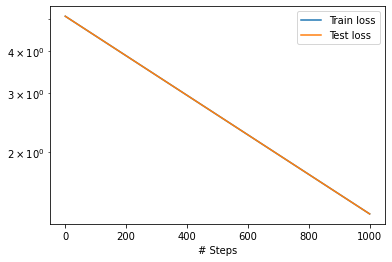

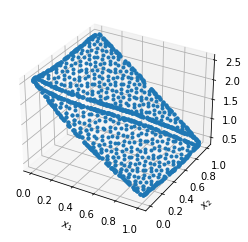

C:\Users\Lyle\AppData\Local\Temp\ipykernel_10376\1579411219.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - ((a/2)/(t-x)) + ((a/2)/(t+x))
C:\Users\Lyle\AppData\Local\Temp\ipykernel_10376\1579411219.py:8: RuntimeWarning: invalid value encountered in add
  return 1 - ((a/2)/(t-x)) + ((a/2)/(t+x))
C:\Users\Lyle\AppData\Local\Temp\ipykernel_10376\1579411219.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


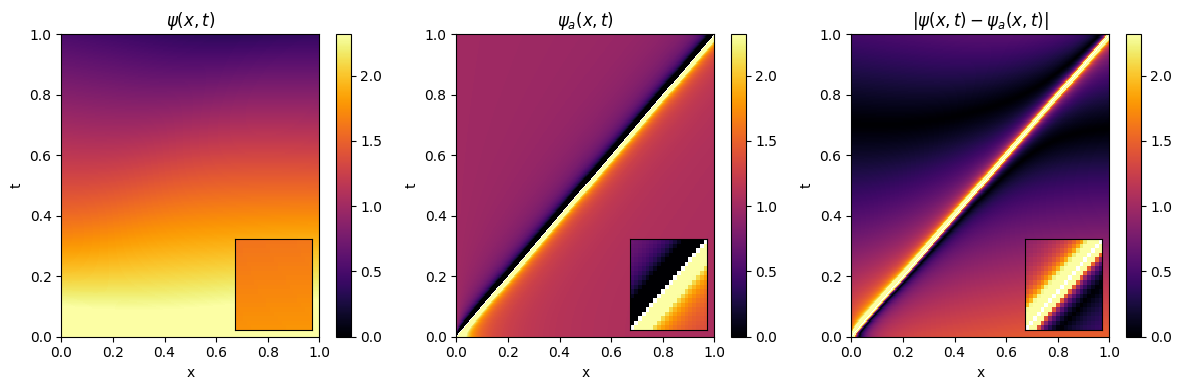

C:\Users\Lyle\AppData\Local\Temp\ipykernel_10376\1579411219.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - ((a/2)/(t-x)) + ((a/2)/(t+x))
C:\Users\Lyle\AppData\Local\Temp\ipykernel_10376\1579411219.py:8: RuntimeWarning: invalid value encountered in add
  return 1 - ((a/2)/(t-x)) + ((a/2)/(t+x))
C:\Users\Lyle\AppData\Local\Temp\ipykernel_10376\1579411219.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


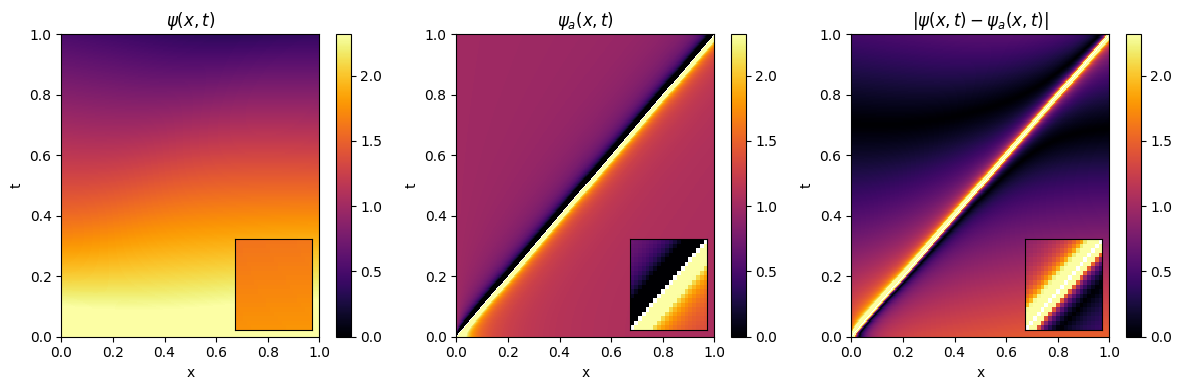

C:\Users\Lyle\AppData\Local\Temp\ipykernel_10376\1579411219.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - ((a/2)/(t-x)) + ((a/2)/(t+x))
C:\Users\Lyle\AppData\Local\Temp\ipykernel_10376\1579411219.py:8: RuntimeWarning: invalid value encountered in add
  return 1 - ((a/2)/(t-x)) + ((a/2)/(t+x))
C:\Users\Lyle\AppData\Local\Temp\ipykernel_10376\1579411219.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


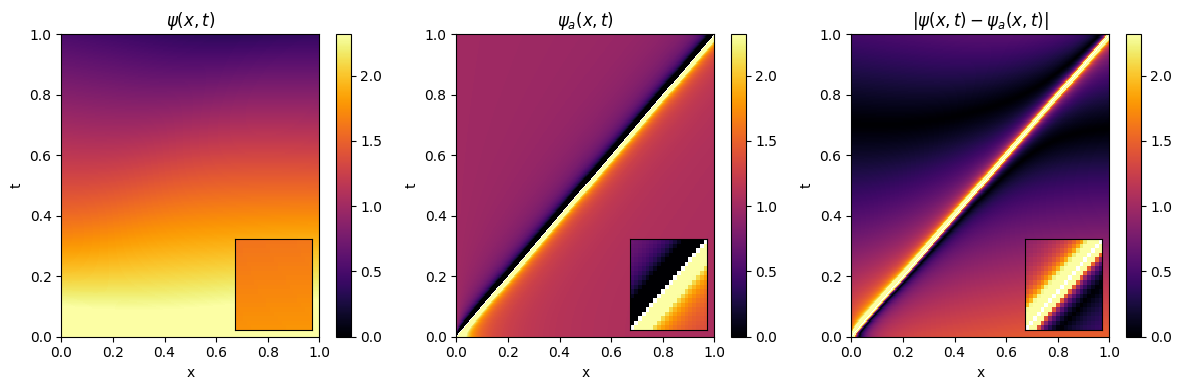

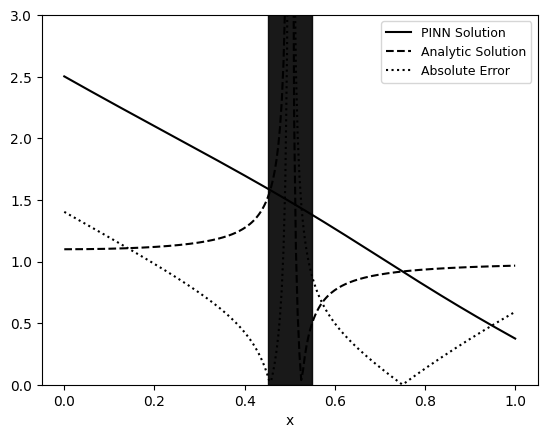

Average Behavior


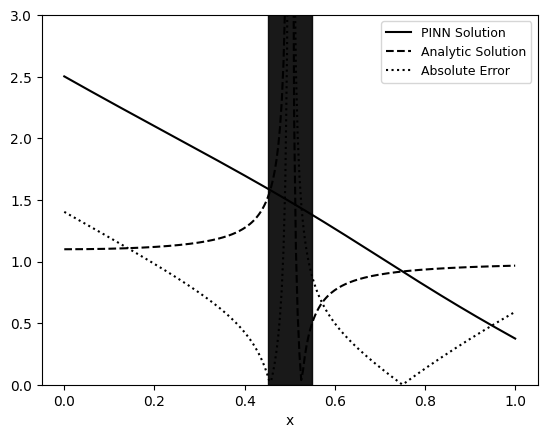

In [15]:

for i in range(sample_size):
    model_10_1 = generate_evolution_model(throat, 500, 500, 10, 1, lr, iterations);
    analytic_v_10_1 += plot_evolution_model(throat, model_10_1)[0];
    v_10_1 += plot_evolution_model(throat, model_10_1)[1];
    diff_10_1 += plot_evolution_model(throat, model_10_1)[2];
    plot_evolution_slice(throat, 0.5, analytic_v_10_1, v_10_1, diff_10_1)
    
    
print("Average Behavior")
analytic_v_10_1 = analytic_v_10_1/sample_size
v_10_1 = v_10_1/sample_size 
diff_10_1 = diff_10_1/sample_size 

plot_evolution_slice(throat, 0.5, analytic_v_10_1, v_10_1, diff_10_1)


In [13]:
def pde(x,y):
    r = x[:, 0:1]
    t = x[:, 1:2]
    dr_t = dde.grad.jacobian(y, t)
    return dr_t - (1-((1/2*r)))/((1+(1/(2*r)))**3)


main_domain = dde.geometry.Rectangle([-5,-5],[5,5])
geom = main_domain 


ic = dde.icbc.DirichletBC(
    geom,
    lambda x: (x[:, 0:1]) - 0.5,
    lambda x, on_boundary:  np.isclose(x[1], 0),
)



data = dde.data.PDE(
    geom, pde, [ic], num_domain=500, num_boundary=500)


net = dde.nn.FNN([2] + [10] * 3 + [1], "tanh", "Glorot normal")


model = dde.Model(data, net)
model.compile("adam", lr=0.01)
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.072330 s



ValueError: None values not supported.

Compiling model...
Building feed-forward neural network...
'build' took 0.069305 s

'compile' took 0.848038 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [8.82e+17]    [8.82e+17]    []  
1000      [nan]         [nan]         []  

Best model at step 0:
  train loss: 8.82e+17
  test loss: 8.82e+17
  test metric: []

'train' took 2.975796 s

Saving loss history to C:\Users\Lyle\Desktop\relativity\numerical-relativity\pinn-horizon-finding\loss.dat ...
Saving training data to C:\Users\Lyle\Desktop\relativity\numerical-relativity\pinn-horizon-finding\train.dat ...
Saving test data to C:\Users\Lyle\Desktop\relativity\numerical-relativity\pinn-horizon-finding\test.dat ...


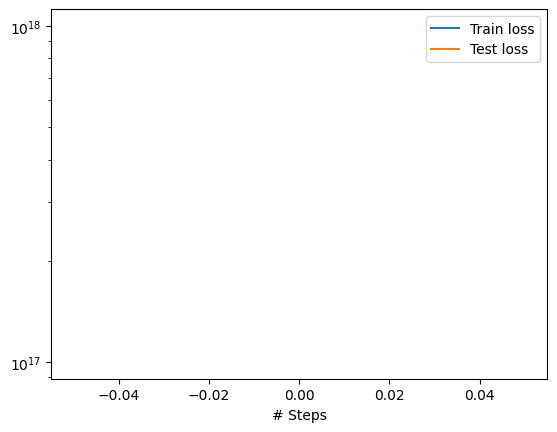

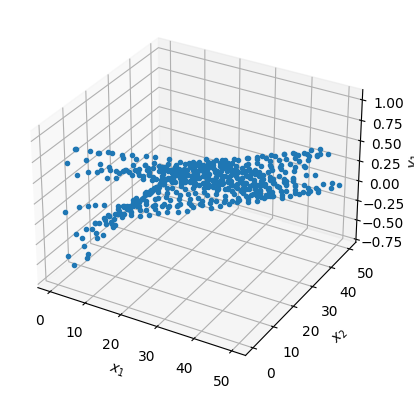

In [44]:
def pde(x, y):
    #dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x)
    return dy_t - (1-((1/2*y)))/((1+(1/(2*y)))**3)


main_domain = dde.geometry.Rectangle([0.1,0.1],[50,50])
geom = main_domain 


# ic = dde.icbc.DirichletBC(
#     geom,
#     lambda x: 1 + 0.01/(x[:, 0:1]),
#     lambda x, on_boundary:  np.isclose(x[1], 0),
# )



data = dde.data.PDE(
    geom, pde, [], num_domain=500, num_boundary=20)


net = dde.nn.FNN([2] + [10] * 3 + [1], "tanh", "Glorot normal")


model = dde.Model(data, net)
model.compile("adam", lr=0.01)
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)